gotta read all the files one by one, store their number of rows, unload the data to avoid ram maxing, and then use that information to decide which .txt are going to be loaded together, keeping into account the max ram available, trying to just drop the last sequence of segments. 

the problem with this is that it's going to be hard to find say 5 continguous file combinations that yield a multiple of 640 (pretty imposible I'd say). So maybe we will have to load the last part of a given .txt, and merge it with the next .txts. The problem with this is that it will be hard to get the prediction to put it into the .txt. 

So what we could do instead is, given that we already have to duplicate the files to keep the backup, we could create new csvs that are split according to multiples of 640, and then store them. And then reload them to include the predictions. 



mod the sheep_name column to contain the location (e.g.: pilca_ov1)

Differentiating walking would improve a lot with gps and maybe longer segment sizes. Would magnetometer help?

OTHER MODELS TO TRAIN:

https://www.kaggle.com/code/abheeshthmishra/predictions-of-human-activity-recognition-96
https://www.kaggle.com/code/docxian/human-activity-recognition-visual-exploration
https://www.kaggle.com/datasets/die9origephit/human-activity-recognition
https://www.kaggle.com/search?q=human+activity+recognition

https://towardsdatascience.com/a-brief-introduction-to-time-series-classification-algorithms-7b4284d31b97

https://towardsdatascience.com/sktime-a-unified-python-library-for-time-series-machine-learning-3c103c139a55



To Do: 
Base model like random forest

cnn without transformer

cnn with transformer

To try: 

- dropout
- batch normalization
- weight decay
- Larger Batch size (model.fit(x_train, y_train, batch_size=64, epochs=10))
- Average Model Predictions(Model ensembling) (# Train 3 models
model1 = train_model(x_train, y_train)
model2 = train_model(x_train, y_train)
model3 = train_model(x_train, y_train)

# Get predictions from each model
preds1 = model1.predict(x_test)
preds2 = model2.predict(x_test)
preds3 = model3.predict(x_test)

# Average the predictions
final_preds = (preds1 + preds2 + preds3) / 3.0)



Do another model that just specializes on Wakling vs Not walking, same architecture, different data. 

https://timeseriesai.github.io/tsai/analysis.html
https://timeseriesai.github.io/tsai/models.explainability.html

https://www.tensorflow.org/tutorials/keras/overfit_and_underfit



In [1]:
import os 
os.chdir('/home/franfram/AAR-DL/')

In [2]:
!pip install -e ./aar_helpers

Obtaining file:///home/franfram/AAR-DL/aar_helpers
  Preparing metadata (setup.py) ... done
  Attempting uninstall: aar-helpers
    Found existing installation: aar-helpers 0.1
    Uninstalling aar-helpers-0.1:
      Successfully uninstalled aar-helpers-0.1
  Running setup.py develop for aar-helpers


In [3]:
import aar_helpers as ad
import numpy as np
import pandas as pd
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
#from tensorflow.keras.utils import plot_model

from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objs as go
from plotly.subplots import make_subplots

import importlib

from pyprojroot.here import here

import aar_helpers as ad

2023-12-05 09:12:33.694260: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-05 09:12:33.720042: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-05 09:12:34.175071: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [4]:
importlib.reload(ad)

<module 'aar_helpers' from '/home/franfram/AAR-DL/aar_helpers/__init__.py'>

https://scikit-learn.org/stable/modules/cross_validation.html#a-note-on-shuffling

https://www.tensorflow.org/tutorials/structured_data/imbalanced_data
Caution: If you want to deploy a model, it's critical that you preserve the preprocessing calculations. The easiest way to implement them as layers, and attach them to your model before export.

In [5]:
??ad.data_pipeline

Signature:
ad.data_pipeline(
    data_path: str = 'data/clean_sheep_data_2019.csv',
    features: List[str] = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'pitch.angle', 'roll.angle'],
    sequence_length: int = 10,
    segment_size: int = 64,
    behaviour_threshold: int = 51,
    move_window_by: str = 'fraction',
    replacements: Dict = {'resting': 'Inactive', 'vigilance': 'Inactive', 'fast_walk': 'Walking', 'walk': 'Walking', 'eating': 'Foraging'},
)
Docstring: <no docstring>
Source:   
def data_pipeline(
    data_path: str='data/clean_sheep_data_2019.csv', 
    features: List[str] = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'pitch.angle', 'roll.angle'],
    sequence_length: int = 10, 
    segment_size: int = 64,
    behaviour_threshold: int = 51,
    move_window_by: str = 'fraction',
    replacements: Dict = {
        'resting': 'Inactive',
        'vigilance': 'Inactive',
        'fast_walk': 'Walking',
        'walk': 'Walking',
        'eating': 'Foraging

In [25]:
tf.random.set_seed(42)
replacements = {
    'resting': 'Inactive',
    'vigilance': 'Inactive',
    'fast_walk': 'Walking',
    'walk': 'Walking',
    'eating': 'Foraging',
    #'search': 'Foraging'
    #'search': 'Walking'
}


data_path = here('data/clean_sheep_data_2019.csv')
#features = ['acc_x', 'acc_y', 'acc_z', 'mag_x', 'mag_y', 'mag_z', 'pitch.angle', 'roll.angle']
features = ['acc_x', 'acc_y', 'acc_z', 'pitch.angle', 'roll.angle']
#features = ['acc_x', 'acc_y', 'acc_z', 'pitch.angle']
"MAYBE ADD THE SMOOTHED LABELS"
allowed_behaviours=['Inactive', 'Walking', 'Foraging']
sequence_length = 15
segment_size = 64
behaviour_threshold = 51
move_window_by = 'fraction'

x_data, y_data, behaviour_mapping, full_data = ad.data_pipeline(
    data_path=data_path, 
    features=features, 
    sequence_length=sequence_length,
    segment_size=segment_size, 
    behaviour_threshold=behaviour_threshold, 
    move_window_by=move_window_by, 
    replacements=replacements
)


x_data, y_data = ad.load_training_data(segment_size=segment_size, sequence_length=sequence_length, behaviour_threshold=behaviour_threshold)


n_features = x_data.shape[2]
n_classes = y_data.shape[2]


x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=False)

label_names = list(behaviour_mapping.keys())

class_weights_dict = ad.compute_class_weights(y_train)

class_weights_dict

Total number of sequences for BF51_SS64_SL15: 745
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy

/home/franfram/.local/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when strategy is interpolate: 0.0%
Percentage of NaNs when stra

{0: 0.8565679793043978, 1: 0.5910353034510115, 2: 7.11217183770883}

In [7]:
importlib.reload(ad)

<module 'aar_helpers' from '/home/franfram/AAR-DL/aar_helpers/__init__.py'>

In [21]:
x_train.shape

(596, 960, 4)

Epoch 1/300
10/10 [==============================] - 4s 55ms/step - loss: 1.2569 - accuracy: 0.2013 - val_loss: 1.4271 - val_accuracy: 0.1405
Epoch 2/300
10/10 [==============================] - 0s 13ms/step - loss: 1.2321 - accuracy: 0.2315 - val_loss: 1.3975 - val_accuracy: 0.1490
Epoch 3/300
10/10 [==============================] - 0s 13ms/step - loss: 1.2090 - accuracy: 0.2468 - val_loss: 1.3650 - val_accuracy: 0.1633
Epoch 4/300
10/10 [==============================] - 0s 13ms/step - loss: 1.1863 - accuracy: 0.2628 - val_loss: 1.3368 - val_accuracy: 0.1714
Epoch 5/300
10/10 [==============================] - 0s 13ms/step - loss: 1.1647 - accuracy: 0.2732 - val_loss: 1.3080 - val_accuracy: 0.1848
Epoch 6/300
10/10 [==============================] - 0s 13ms/step - loss: 1.1442 - accuracy: 0.2808 - val_loss: 1.2776 - val_accuracy: 0.2040
Epoch 7/300
10/10 [==============================] - 0s 13ms/step - loss: 1.1244 - accuracy: 0.2884 - val_loss: 1.2523 - val_accuracy: 0.2228
Epoch 

5/5 [==============================] - 0s 3ms/step


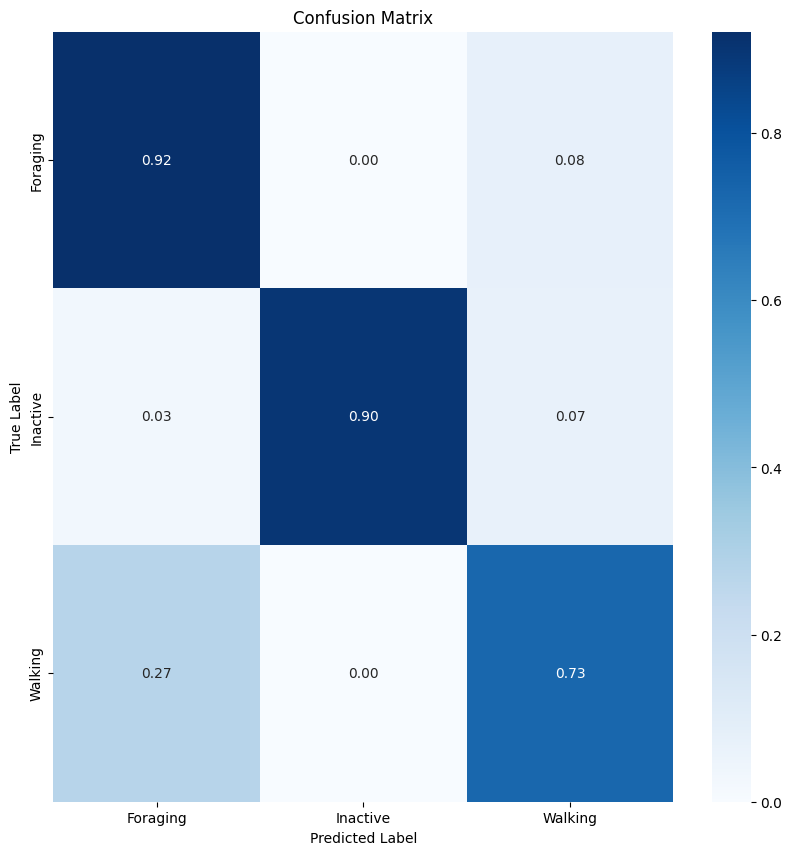

In [20]:

# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
# https://lambdalabs.com/blog/tensorflow-2-0-tutorial-03-saving-checkpoints
lr=1e-6
#lr=1e-5
#lr=1e-3
epochs=300
#epochs=500
#epochs=2000
patience=50


earlystop_callback = tf.keras.callbacks.EarlyStopping(
    #monitor='val_accuracy', min_delta=0.0001, patience=20
    monitor='val_loss', min_delta=0.0001, patience=20
)

#from tensorflow.keras.callbacks import ModelCheckpoint

## define a callback to save the model after each epoch
#checkpoint_filepath = '/tmp/checkpoint'
#checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1,  monitor='val_loss', save_best_only=False, mode='auto')


# Define a callback to save the model after each epoch
checkpoint = ModelCheckpoint('model-{epoch:03d}.keras', verbose=1, monitor='val_loss', save_best_only=False, mode='auto')

## Pass the callback to the fit method
#model.fit(x_train, y_train, epochs=100, callbacks=[checkpoint])




x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=False)

label_names = list(behaviour_mapping.keys())

class_weights_dict = ad.compute_class_weights(y_train)



model = ad.make_model(segment_size=segment_size, sequence_length=sequence_length, nfeatures=n_features, nclasses=n_classes, cnn_only=False, dropout_rate=0)
#model = define_convTransformer_dropout(segment_size=segment_size, sequence_length=sequence_length, nfeatures=n_features, nclasses=n_classes, dropout_rate=0.05)

model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    optimizer=tf.keras.optimizers.experimental.Adadelta(), 
    #loss='categorical_crossentropy',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=10),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=['accuracy']
    #metrics=['precision']
    #metrics=['accuracy', 'precision']#, 'recall']# 'AUC', 'AUPRC'] #Accuracy is not an useful metric here?
    #metrics=tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
)

fit = model.fit(
    #x = x_data, 
    #y = y_data, 
    x = x_train, 
    y = y_train,
    #batch_size=32, 
    batch_size=64, 
    #epochs=200, 
    epochs=epochs, 
    validation_data=(x_val, y_val),
    #validation_split=0.2
    callbacks=[earlystop_callback],
    class_weight=class_weights_dict
)


ad.plot_loss(fit)
ad.plot_confusion_matrix(model, x_val, y_val, label_names)

Epoch 1/100
10/10 [==============================] - 0s 33ms/step - loss: 0.2519 - accuracy: 0.9347 - val_loss: 0.2129 - val_accuracy: 0.9280
Epoch 2/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2517 - accuracy: 0.9352 - val_loss: 0.2147 - val_accuracy: 0.9275
Epoch 3/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2518 - accuracy: 0.9341 - val_loss: 0.2133 - val_accuracy: 0.9284
Epoch 4/100
10/10 [==============================] - 0s 12ms/step - loss: 0.2515 - accuracy: 0.9352 - val_loss: 0.2125 - val_accuracy: 0.9280
Epoch 5/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2512 - accuracy: 0.9356 - val_loss: 0.2123 - val_accuracy: 0.9280
Epoch 6/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2511 - accuracy: 0.9352 - val_loss: 0.2115 - val_accuracy: 0.9280
Epoch 7/100
10/10 [==============================] - 0s 13ms/step - loss: 0.2510 - accuracy: 0.9355 - val_loss: 0.2114 - val_accuracy: 0.9280
Epoch 

5/5 [==============================] - 0s 3ms/step


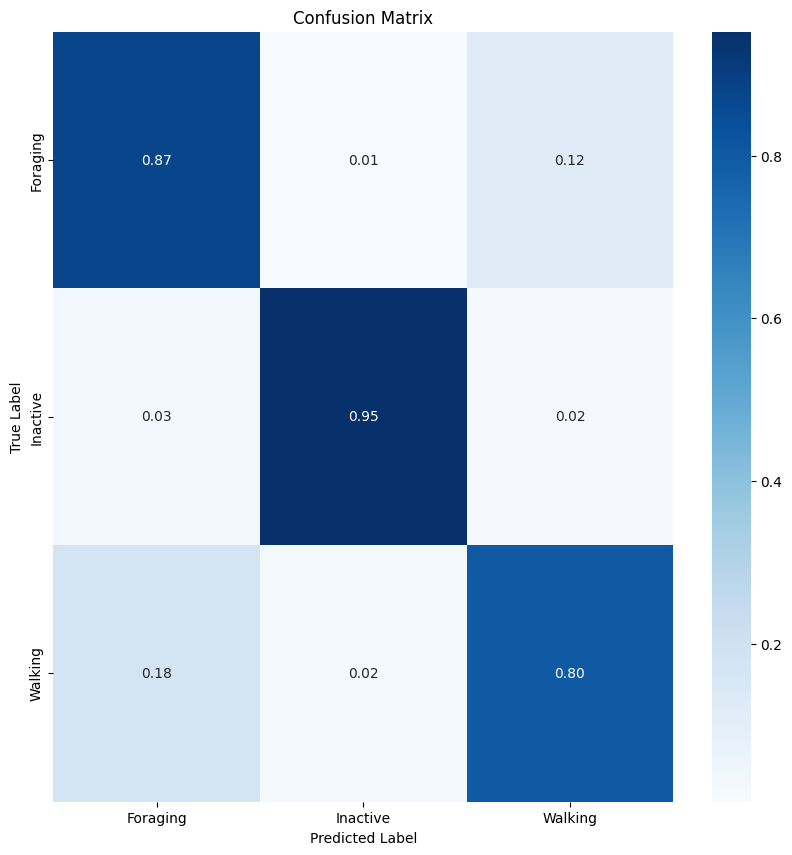

In [64]:
fit = model.fit(
    #x = x_data, 
    #y = y_data, 
    x = x_train, 
    y = y_train,
    #batch_size=32, 
    batch_size=64, 
    #epochs=200, 
    epochs=100, 
    validation_data=(x_val, y_val),
    #validation_split=0.2
    callbacks=[earlystop_callback],
    class_weight=class_weights_dict
)


ad.plot_loss(fit)
ad.plot_confusion_matrix(model, x_val, y_val, label_names)

5/5 [==============================] - 0s 13ms/step


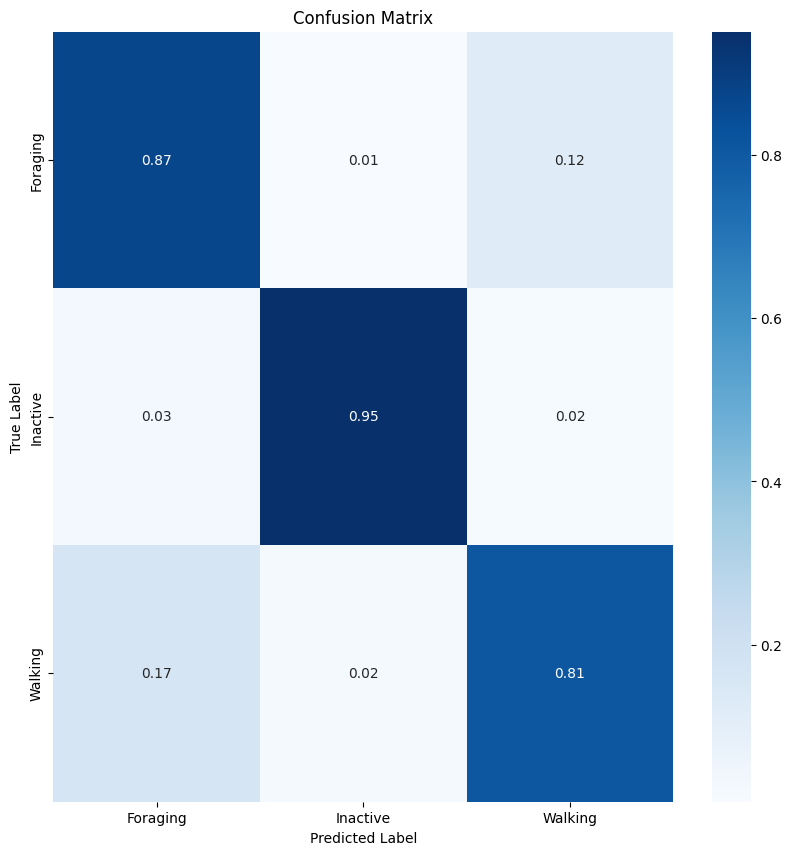

In [9]:

ad.plot_confusion_matrix(model, x_val, y_val, label_names)

In [12]:
model_name='model_879581'
#model.save(f'./data/{model_name}.keras')

5/5 [==============================] - 0s 6ms/step


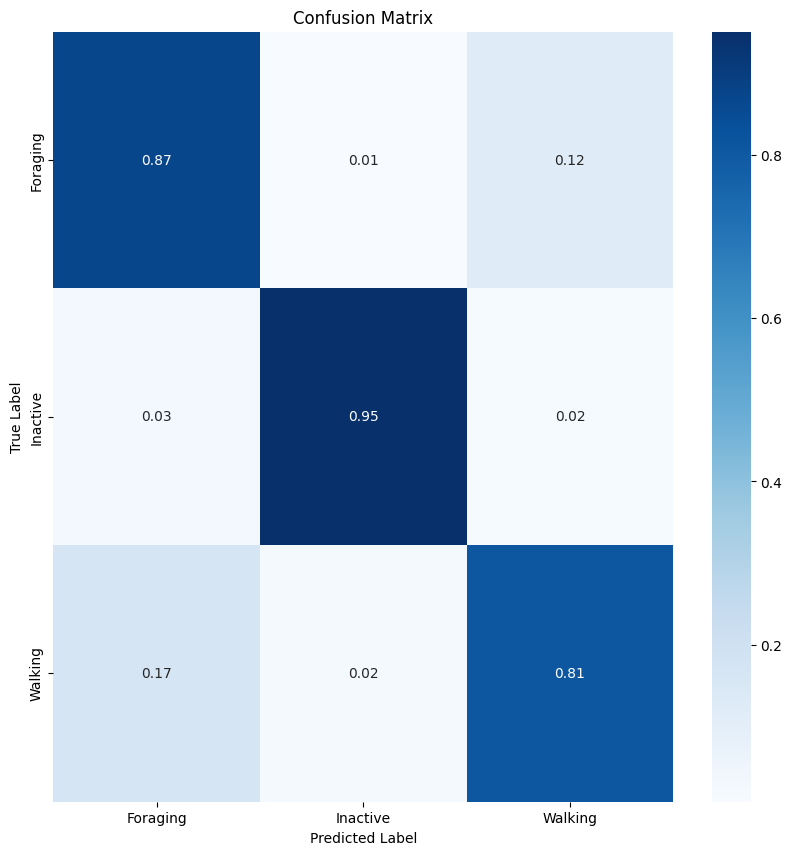

In [27]:
model_name='model_879581'
model = load_model(f"./data/{model_name}.keras")

ad.plot_confusion_matrix(model, x_val, y_val, label_names)

In [22]:
predictions.shape, np.max(predictions, axis=-1).shape

((149, 15, 3), (149, 15))

5/5 [==============================] - 0s 10ms/step


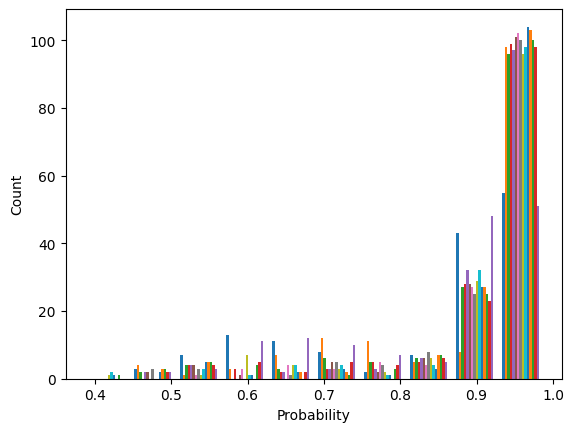

In [16]:
loaded_model = load_model(f'{model_name}.keras')

predictions=loaded_model.predict(x_val)
predictions
# Assume `predictions` are the output of model.predict
probabilities = np.max(predictions, axis=-1)
plt.hist(probabilities, bins=10)
plt.xlabel('Probability')
plt.ylabel('Count')
plt.show()

In [31]:
max_probs.shape, max_probs.flatten().shape

((149, 15), (2235,))

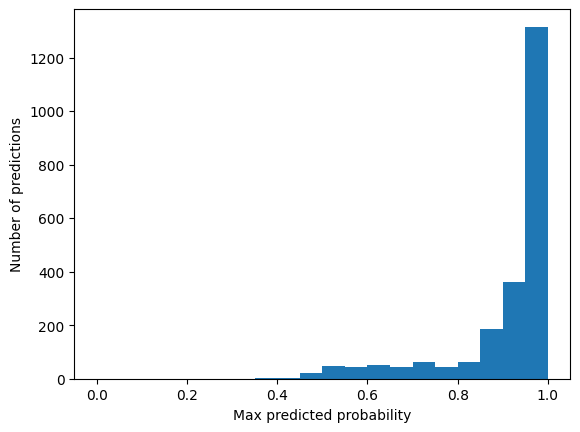

In [24]:
# Calculate the maximum predicted probability for each label in each sequence
max_probs = np.max(predictions, axis=-1)

# Flatten this array to get a 1D array of all maximum probabilities
max_probs_flat = max_probs.flatten()

# Plot a histogram of these maximum probabilities
plt.hist(max_probs_flat, bins=20, range=(0, 1))
plt.xlabel('Max predicted probability')
plt.ylabel('Number of predictions')
plt.show()

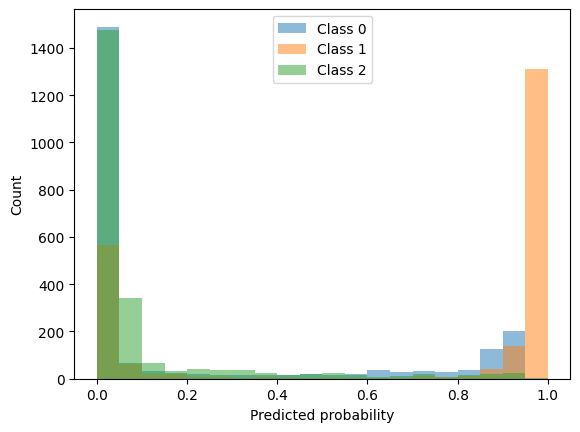

In [33]:
# Assume `predictions` are the output of model.predict
# predictions shape: (n_samples, number_of_labels_per_sample, number_of_classes)

# Reshape predictions to 2D array: (n_samples * number_of_labels_per_sample, number_of_classes)
predictions_reshaped = predictions.reshape(-1, predictions.shape[-1])

# Plot a histogram for each class
for i in range(predictions.shape[-1]):
    plt.hist(predictions_reshaped[:, i], bins=20, range=(0, 1), alpha=0.5, label=f'Class {i}')

plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.legend()
plt.show()

In [39]:
label_names[0]

'Foraging'

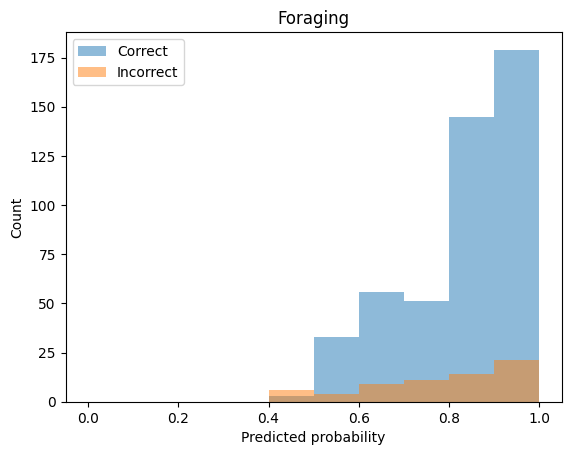

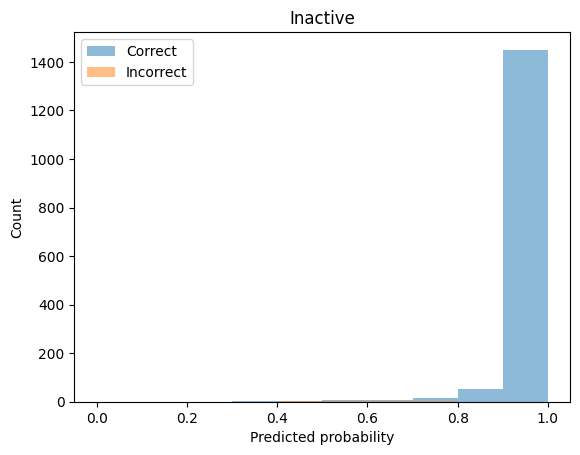

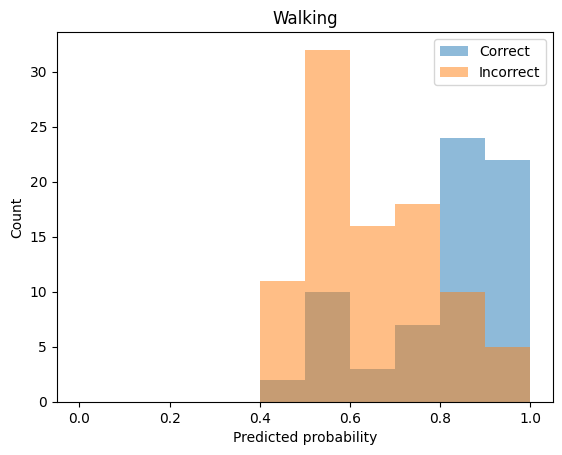

In [41]:
# Compute the true class labels
y_true_classes = np.argmax(y_val, axis=-1)

# Compute the predicted class labels
y_pred_classes = np.argmax(predictions, axis=-1)

for i in range(predictions.shape[-1]):
    # Compute the predicted probabilities for this class
    pred_probs = predictions_reshaped[:, i]

    # Find where the model correctly predicted this class
    correct_mask = (y_true_classes == i) & (y_pred_classes == i)
    correct_probs = pred_probs[correct_mask.flatten()]

    # Find where the model incorrectly predicted this class
    incorrect_mask = (y_true_classes != i) & (y_pred_classes == i)
    incorrect_probs = pred_probs[incorrect_mask.flatten()]

    # Plot histograms
    plt.hist(correct_probs, bins=10, range=(0, 1), alpha=0.5, label='Correct')
    plt.hist(incorrect_probs, bins=10, range=(0, 1), alpha=0.5, label='Incorrect')
    plt.title(f'{label_names[i]}')
    plt.xlabel('Predicted probability')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

In [17]:
probabilities

array([[0.955859  , 0.97720534, 0.9779433 , ..., 0.9860633 , 0.9719506 ,
        0.9675531 ],
       [0.8200904 , 0.91720146, 0.9385203 , ..., 0.9858948 , 0.9684931 ,
        0.9692087 ],
       [0.9659515 , 0.9749864 , 0.981505  , ..., 0.98517066, 0.97168744,
        0.9571702 ],
       ...,
       [0.8380405 , 0.8297291 , 0.88694614, ..., 0.5548018 , 0.48940334,
        0.6287649 ],
       [0.5067821 , 0.69889146, 0.5483907 , ..., 0.49739355, 0.5062883 ,
        0.7045414 ],
       [0.71402323, 0.50506556, 0.6279456 , ..., 0.86288667, 0.78618103,
        0.6582495 ]], dtype=float32)

In [16]:
importlib.reload(ad)

<module 'aar_helpers' from '/home/franfram/AAR-DL/aar_helpers/__init__.py'>

In [17]:

ad.plot_confusion_matrix(model, x_val, y_val, label_names)

5/5 [==============================] - 0s 10ms/step


NameError: name 'np' is not defined

In [ ]:
import pickle

# Save to disk
with open('full_data.pkl', 'wb') as f:
    pickle.dump(full_data, f)

# Load from disk
with open('full_data.pkl', 'rb') as f:
    loaded_dict = pickle.load(f)

In [ ]:
loaded_dict.keys()

dict_keys(['BT51_SS64_SL20'])

In [ ]:
loaded_dict['BT51_SS64_SL10'].keys()

KeyError: 'BT51_SS64_SL10'

In [ ]:
loaded_dict['BT51_SS64_SL10']['ov1.'].keys()

NameError: name 'loaded_dict' is not defined

In [ ]:
print("pandas version", pd.__version__)
print("numpy version", np.__version__)

pandas version 2.1.3
numpy version 1.24.3


In [ ]:
#metrics = [
    #tf.keras.metrics.Precision(name='precision'),
    #tf.keras.metrics.Recall(name='recall'), 
    #tf.keras.metrics.AUC(name='auc'), 
    #tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy'),
    #tf.keras.metrics.CategoricalHinge(name='categorical_hinge'),
    #tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy'),
    #tf.keras.metrics.OneHotIoU(name='iou'),
    


    #tf.keras.metrics.TruePositives(name='tp'),
    #tf.keras.metrics.TrueNegatives(name='fp'),


#]



#metrics=[tf.keras.metrics.Accuracy(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tf.keras.metrics.AUC(), tf.keras.metrics.AUC(curve='PR')]

CALLBACKS

In [ ]:
# https://towardsdatascience.com/a-practical-introduction-to-early-stopping-in-machine-learning-550ac88bc8fd
# https://lambdalabs.com/blog/tensorflow-2-0-tutorial-03-saving-checkpoints


earlystop_callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy', min_delta=0.0001, patience=20
)

#from tensorflow.keras.callbacks import ModelCheckpoint

## define a callback to save the model after each epoch
#checkpoint_filepath = '/tmp/checkpoint'
#checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(checkpoint_filepath, verbose=1,  monitor='val_loss', save_best_only=False, mode='auto')


# Define a callback to save the model after each epoch
checkpoint = ModelCheckpoint('model-{epoch:03d}.h5', verbose=1, monitor='val_loss', save_best_only=False, mode='auto')

## Pass the callback to the fit method
#model.fit(x_train, y_train, epochs=100, callbacks=[checkpoint])




x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2, random_state=42, shuffle=False)

label_names = list(behaviour_mapping.keys())

class_weights_dict, data_distribution = ad.compute_class_weights(y_train)



lr=1e-6
#lr=1e-5
#lr=1e-3
epochs=300
epochs=500
epochs=2000

model = ad.define_convTransformer(segment_size=segment_size, sequence_length=sequence_length, nfeatures=n_features, nclasses=n_classes)
#model = define_convTransformer_dropout(segment_size=segment_size, sequence_length=sequence_length, nfeatures=n_features, nclasses=n_classes, dropout_rate=0.05)

model.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
    optimizer=tf.keras.optimizers.experimental.Adadelta(), 
    #loss='categorical_crossentropy',
    loss=tf.keras.losses.CategoricalCrossentropy(),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(gamma=10),
    #loss=tf.keras.losses.CategoricalFocalCrossentropy(),
    metrics=['accuracy']
    #metrics=['precision']
    #metrics=['accuracy', 'precision']#, 'recall']# 'AUC', 'AUPRC'] #Accuracy is not an useful metric here?
    #metrics=tf.keras.metrics.CategoricalAccuracy(name='categorical_accuracy')
)

fit = model.fit(
    #x = x_data, 
    #y = y_data, 
    x = x_train, 
    y = y_train,
    #batch_size=32, 
    batch_size=64, 
    #epochs=200, 
    epochs=epochs, 
    validation_data=(x_val, y_val),
    #validation_split=0.2
    callbacks=[earlystop_callback],
    class_weight=class_weights_dict
)


ad.plot_loss(fit)
ad.plot_confusion_matrix(model, x_val, y_val, label_names)

In [27]:
model

<bound method Model.fit of <keras.src.engine.functional.Functional object at 0x7f95746b1a10>>

In [232]:
ad.plot_loss(fit)

8/8 [==============================] - 0s 9ms/step


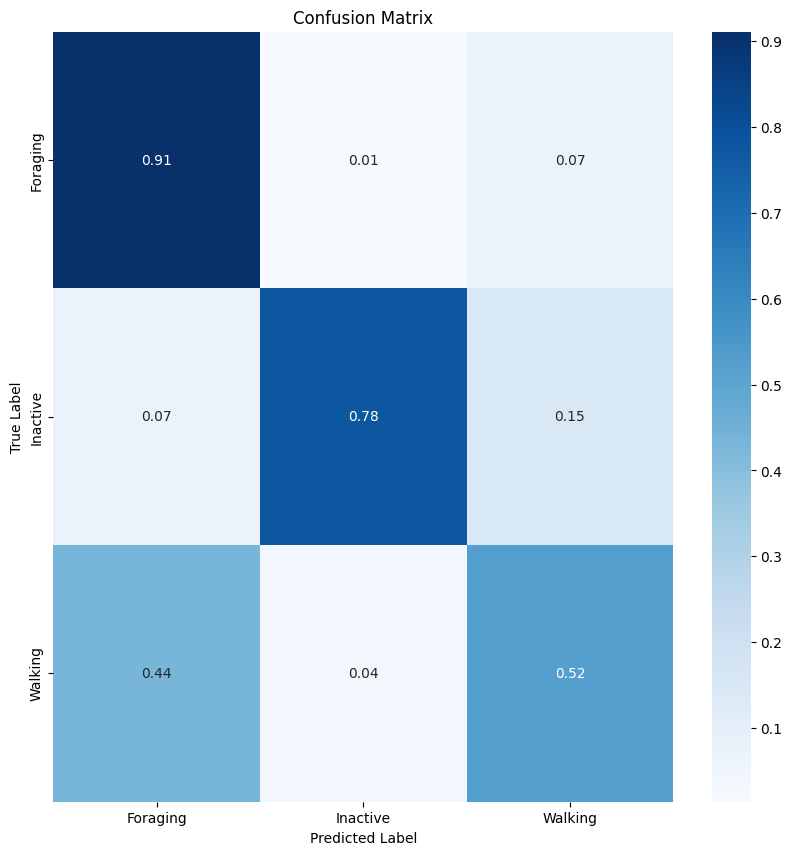

In [233]:



plot_confusion_matrix(model, x_val, y_val, label_names)

#y_pred, y_pred.shape, y_pred_classes_minus1, y_pred_classes_minus1.shape, y_pred_classes_2, y_pred_classes_2.shape

#y_pred.shape, y_pred_classes.shape, y_pred_flat.shape

In [111]:
#y_pred_classes
y_pred_flat

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [91]:
np.set_printoptions(threshold=np.inf)
#np.set_printoptions()

In [92]:
y_pred.shape, y_pred

((238, 10, 3),
 array([[[0.13686523, 0.8005952 , 0.06253957],
         [0.10216883, 0.84924656, 0.04858455],
         [0.07551986, 0.870353  , 0.05412718],
         [0.08486199, 0.85389847, 0.06123954],
         [0.08462065, 0.86095196, 0.05442733],
         [0.0870911 , 0.8590545 , 0.05385434],
         [0.09071968, 0.8543675 , 0.05491282],
         [0.11677451, 0.82912004, 0.05410546],
         [0.09434543, 0.8542568 , 0.0513977 ],
         [0.05874835, 0.83501905, 0.10623267]],
 
        [[0.13922548, 0.80324805, 0.05752642],
         [0.09875407, 0.8489241 , 0.0523218 ],
         [0.07738326, 0.8712354 , 0.05138135],
         [0.0883257 , 0.85636985, 0.05530448],
         [0.08684837, 0.85499   , 0.05816163],
         [0.08493337, 0.85556215, 0.05950444],
         [0.08539248, 0.85781115, 0.05679646],
         [0.11268561, 0.83383936, 0.05347509],
         [0.08997526, 0.8604042 , 0.0496205 ],
         [0.0578723 , 0.8385845 , 0.10354315]],
 
        [[0.13359721, 0.81563723, 0.050

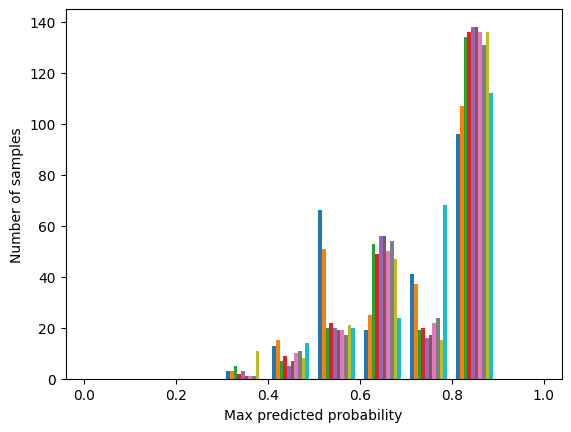

In [107]:
import matplotlib.pyplot as plt

# Get the maximum predicted probability for each sample
max_probs = np.max(y_pred, axis=-1)

# Plot a histogram of these probabilities
plt.hist(max_probs, bins=10, range=(0, 1))
plt.xlabel('Max predicted probability')
plt.ylabel('Number of samples')
plt.show()

#OLD

In [2]:
def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    for _ in range(7):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x)

    # Adding the self attention to the original sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Position-wise Feed-Forward Part
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # Adding the position-wise feedforward to the sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model2 = define_convTransformer()

2023-11-20 11:20:27.014286: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-11-20 11:20:27.135933: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [133]:
# x_train_convT = np.load('../data/x_train.npy')
# y_train_convT = np.load('../data/y_train.npy')

#x_train_convT = np.load('../data/x_train_75.npy')
#y_train_convT = np.load('../data/y_train_75.npy')



In [121]:
np.isnan(x_train_convT).sum() / x_train_convT.size

0.0

In [122]:
x_train_convT.shape, y_train_convT.shape

((895, 640, 8), (895, 10, 3))

In [134]:
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [9]:
fit2 = model2.fit(
    x=x_train_convT,
    y=y_train_convT,
    batch_size=32,
    epochs=50,
    validation_split=0.2
)

Epoch 1/50
12/12 [==============================] - 2s 49ms/step - loss: 0.5814 - accuracy: 0.8218 - val_loss: 0.2257 - val_accuracy: 0.9453
Epoch 2/50
12/12 [==============================] - 0s 27ms/step - loss: 0.3426 - accuracy: 0.9167 - val_loss: 0.1825 - val_accuracy: 0.9453
Epoch 3/50
12/12 [==============================] - 0s 27ms/step - loss: 0.2580 - accuracy: 0.9220 - val_loss: 0.1517 - val_accuracy: 0.9453
Epoch 4/50
12/12 [==============================] - 0s 26ms/step - loss: 0.2025 - accuracy: 0.9310 - val_loss: 0.1443 - val_accuracy: 0.9474
Epoch 5/50
12/12 [==============================] - 0s 27ms/step - loss: 0.1623 - accuracy: 0.9443 - val_loss: 0.1240 - val_accuracy: 0.9516
Epoch 6/50
12/12 [==============================] - 0s 29ms/step - loss: 0.1621 - accuracy: 0.9485 - val_loss: 0.1448 - val_accuracy: 0.9516
Epoch 7/50
12/12 [==============================] - 0s 27ms/step - loss: 0.1407 - accuracy: 0.9554 - val_loss: 0.0982 - val_accuracy: 0.9726
Epoch 8/50
12

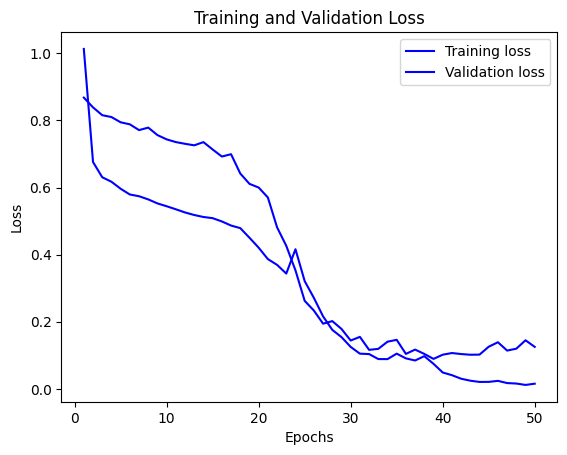

In [11]:
import matplotlib.pyplot as plt

history = fit2.history

train_loss = history['loss']
val_loss = history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Plotting
plt.plot(epochs, train_loss, 'b', label='Training loss')  # 'bo' gives dot plot
plt.plot(epochs, val_loss, 'b', label='Validation loss')   # 'b' gives line plot
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

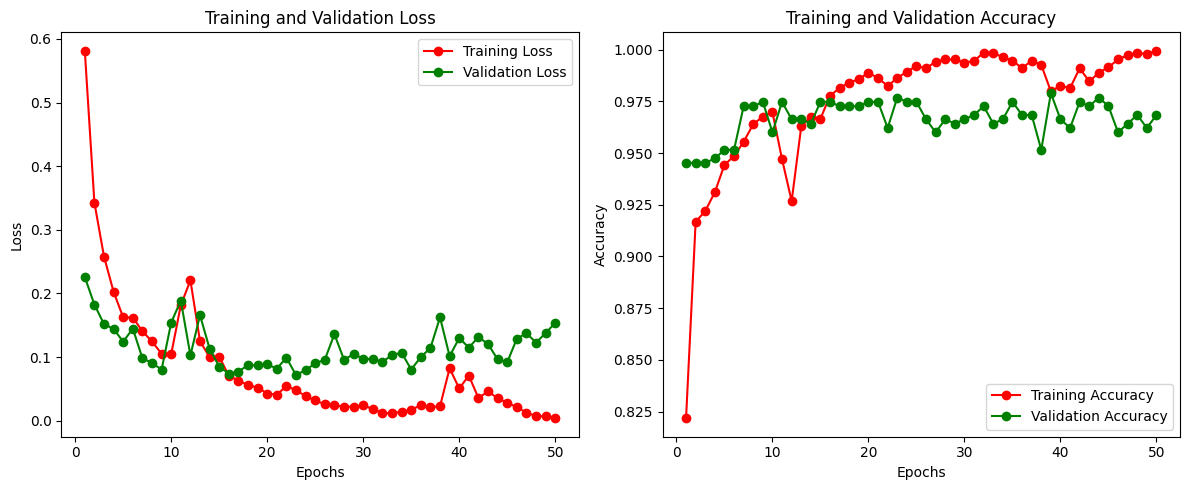

In [10]:
import matplotlib.pyplot as plt

history = fit2.history

# Assuming 'history' is your history object returned by the 'fit' method
train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
epochs = range(1, len(train_loss) + 1)

# Plotting training and validation loss
plt.figure(figsize=(12, 5))

# First subplot for loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss', marker='o')  # Red color for training loss
plt.plot(epochs, val_loss, 'g', label='Validation Loss', marker='o')  # Green color for validation loss
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Second subplot for accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy', marker='o')  # Red color for training accuracy
plt.plot(epochs, val_acc, 'g', label='Validation Accuracy', marker='o')  # Green color for validation accuracy
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [41]:
predictions = model2.predict(x_train_convT)
predicted_labels = np.argmax(predictions, axis = -1).flatten()

predicted_labels.shape, predicted_labels

15/15 [==============================] - 0s 8ms/step


((2360,), array([0, 0, 0, ..., 0, 0, 0]))

(array([2.36228814, 0.        , 0.        , 0.        , 0.        ,
        2.33050847, 0.        , 0.        , 0.        , 0.30720339]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

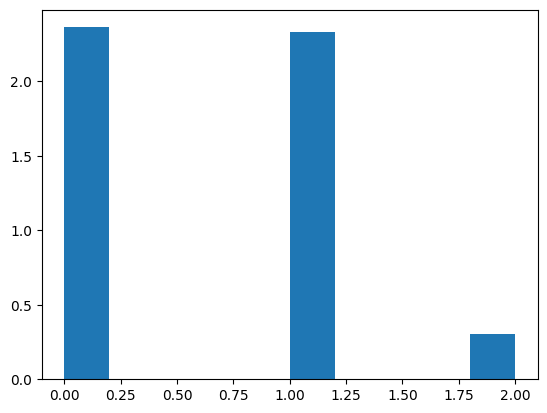

In [67]:
predicted_labels.shape

plt.hist(predicted_labels.flatten(), density=True)

In [47]:
import plotly.graph_objects as go
from collections import Counter

data = predicted_labels.flatten()

fig = go.Figure(data=[
    go.Histogram(x=data, histnorm='probability density')
])

fig.show()


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Text(0.5, 1.0, 'holi')

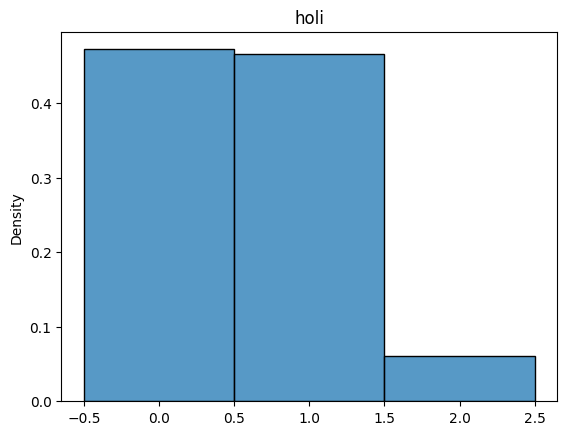

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt


data = predicted_labels.flatten()


sns.histplot(data, bins=[0, 1, 2, 3], stat='density', discrete=True)



In [ ]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot using matplotlib
plt.figure(figsize=(10,10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(classes))  # Replace `classes` with your list of classes
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

# Labeling the plot
thresh = cm.max() / 2.  # for text color
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j],
             horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# If you want a nicer visualization, use seaborn
plt.figure(figsize=(10,10))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)
plt.show()

In [143]:
# def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

def define_convTransformer(segment_size, sequence_length, nfeatures, nclasses):
    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    # for _ in range(7):
    for _ in range(5):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x) # this is the W matrix that computes the query with the X. #if key_dim is 2, you get a 2 dim vector for each `word` # same thing for the matrix that computes the Keys, the matrix that computes the keys and the querys has to have the same dim. 

    # Adding the self attention to the original sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Position-wise Feed-Forward Part
    x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # Adding the position-wise feedforward to the sequence
    x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension
    # x = layers.Conv1D(filters=8, kernel_size=1, activation='relu')(x) # por que esta esta aca? estaba descomentada antes

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model3 = define_convTransformer(segment_size=64, sequence_length=10, nfeatures=8, nclasses=3)
#check spatial positioning encoding. It's in attention is all you need paper. 



In [144]:
model3.summary()

Model: "model_29"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_30 (InputLayer)       [(None, 640, 8)]             0         []                            
                                                                                                  
 conv1d_287 (Conv1D)         (None, 640, 64)              1600      ['input_30[0][0]']            
                                                                                                  
 max_pooling1d_215 (MaxPool  (None, 320, 64)              0         ['conv1d_287[0][0]']          
 ing1D)                                                                                           
                                                                                                  
 conv1d_288 (Conv1D)         (None, 320, 64)              12352     ['max_pooling1d_215[0][

In [20]:
y_train_convT

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]])

In [142]:
x_train.shape, y_train.shape

((736, 640, 8), (736, 10, 3))

In [84]:
https://www.tensorflow.org/api_docs/python/tf/keras/Model



  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post11-py3-none-any.whl size=2959 sha256=e364dd4c79174709d309db647518d3c7f3201f02974f0547199e72b8839fb32c
  Stored in directory: /home/franfram/.cache/pip/wheels/52/cc/47/500a56407c060a5d18bda9aa3ec2daf4721b8448ee4b268840
Successfully built sklearn


In [135]:
from sklearn.model_selection import train_test_split
#while val split is not balanced repeat this
x_train, x_val, y_train, y_val = train_test_split(x_train_convT, y_train_convT, test_size=0.2, shuffle=True)

In [136]:
y_train.shape, y_val.shape

((736, 10, 3), (185, 10, 3))

In [137]:
from sklearn.utils import class_weight
import numpy as np

# Flatten the timestep and one-hot dimensions of your labels
# This will give you a 2D array of shape (472 * 5, 3), treating each timestep as a sample
y_train_flat = y_train.reshape(-1, y_train.shape[-1])

# Convert one-hot encoded labels to integers
y_train_integers = np.argmax(y_train_flat, axis=1)

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_integers),
    y=y_train_integers)

# Convert class weights to a dictionary to pass it to Keras
class_weights_dict = dict(enumerate(class_weights))
class_weights_dict

{0: 0.724766125061546, 1: 0.68663121559847, 2: 6.102819237147595}

(array([2.29959239, 0.        , 0.        , 0.        , 0.        ,
        2.42730978, 0.        , 0.        , 0.        , 0.27309783]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

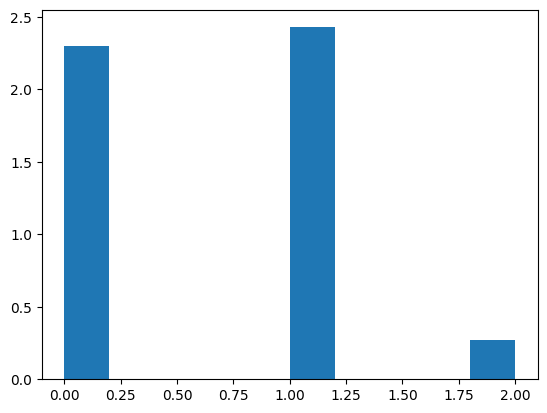

In [139]:
import matplotlib.pyplot as plt
plt.hist(y_train_integers, density=True)



In [49]:
# class_weights_dict[2] = 4
class_weights_dict

{0: 0.7059925093632958, 1: 0.7067866516685414, 2: 5.927672955974843}

In [141]:
x_train.shape, y_train.shape

((736, 640, 8), (736, 10, 3))

In [145]:


model3 = define_convTransformer(segment_size=64, sequence_length=10, nfeatures=8, nclasses=3)


model3.summary()

model3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



# # fit3 = model3.fit(
# #     x=x_train_convT,
# #     y=y_train_convT,
# #     batch_size=32,
# #     epochs=50,
# #     validation_split=0.2,
# #     shuffle=True,
# #     class_weight=class_weights_dict
# # )



fit5 = model3.fit(
    x=x_train,
    y=y_train,
    batch_size=32,
    epochs=70,
    validation_data=(x_val, y_val),
    class_weight=class_weights_dict
)




Model: "model_30"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_31 (InputLayer)       [(None, 640, 8)]             0         []                            
                                                                                                  
 conv1d_295 (Conv1D)         (None, 640, 64)              1600      ['input_31[0][0]']            
                                                                                                  
 max_pooling1d_221 (MaxPool  (None, 320, 64)              0         ['conv1d_295[0][0]']          
 ing1D)                                                                                           
                                                                                                  
 conv1d_296 (Conv1D)         (None, 320, 64)              12352     ['max_pooling1d_221[0][

In [146]:
plot_metrics(fit5)

In [97]:
x_train.shape, y_train.shape

((759, 640, 8), (759, 10, 3))

6/6 [==============================] - 0s 8ms/step


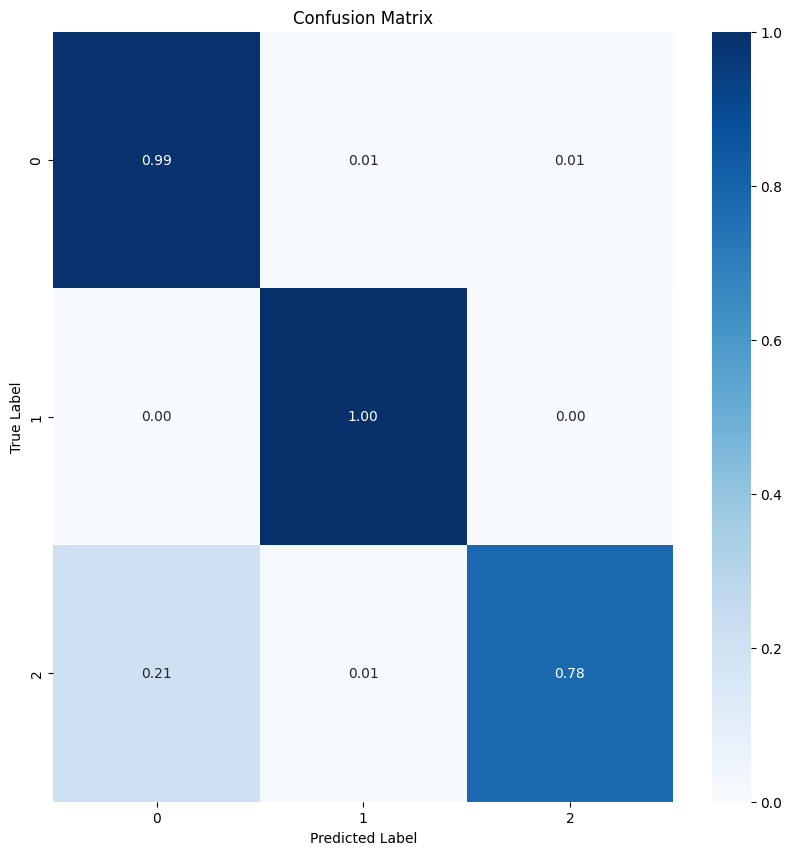

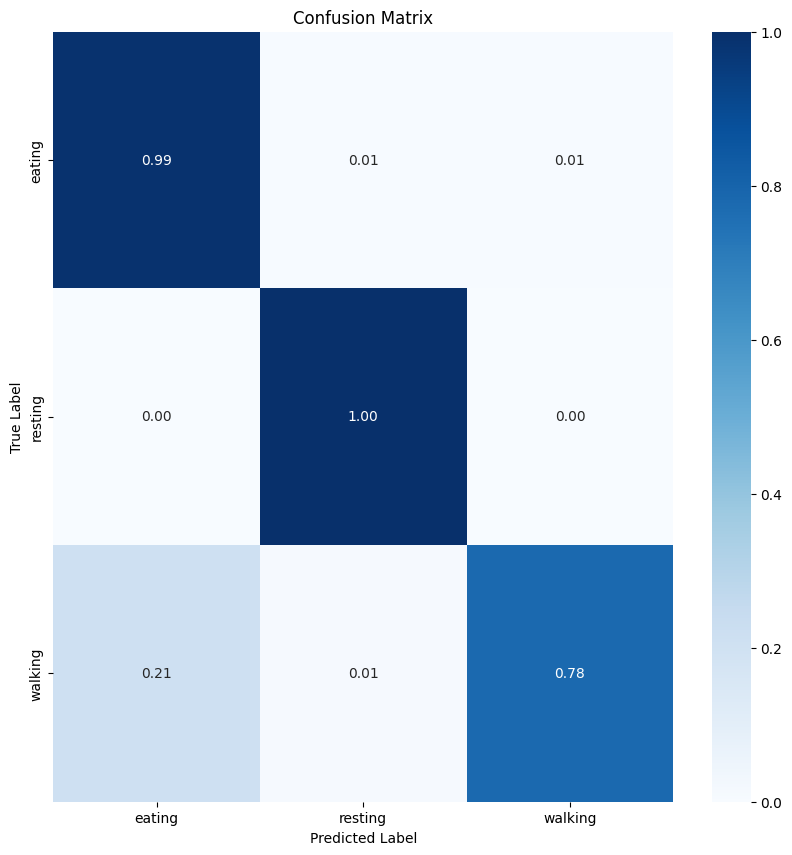

In [147]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test data
y_pred = model3.predict(x_val)

# Convert predictions from probability to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)  # Assuming softmax output
y_true_classes = np.argmax(y_val, axis=-1)  # Convert true labels

# Reshape the predictions and true values to a 2D format
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
# If you want, you can also normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Define your label names corresponding to the integers
label_names = ['eating', 'resting', 'walking']  # Replace with your actual label names

# Create the confusion matrix plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)  # Set custom labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
https://www.tensorflow.org/tutorials/structured_data/imbalanced_data



In [30]:
model3.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_5 (InputLayer)        [(None, 1280, 8)]            0         []                            
                                                                                                  
 conv1d_40 (Conv1D)          (None, 1280, 64)             1600      ['input_5[0][0]']             
                                                                                                  
 max_pooling1d_32 (MaxPooli  (None, 640, 64)              0         ['conv1d_40[0][0]']           
 ng1D)                                                                                            
                                                                                                  
 conv1d_41 (Conv1D)          (None, 640, 64)              12352     ['max_pooling1d_32[0][0]

In [24]:
val_acc[10]

0.9494736790657043

In [53]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots



def plot_metrics(fit):

    history = fit.history
    train_loss = history['loss']
    val_loss = history['val_loss']
    train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
    val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
    epochs = list(range(1, len(train_loss) + 1))

    # Create subplots: one row, two columns
    fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Loss', 'Training and Validation Accuracy'))

    # Define hover template
    hovertemplate = 'Epoch: %{x}<br>Value: %{y:.4f}<extra></extra>'

    # First subplot for loss
    fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss', 
                            marker_color='red', hovertemplate=hovertemplate), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss', 
                            marker_color='green', hovertemplate=hovertemplate), row=1, col=1)

    # Second subplot for accuracy
    fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy', 
                            marker_color='red', hovertemplate=hovertemplate), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy', 
                            marker_color='green', hovertemplate=hovertemplate), row=1, col=2)

    # Update xaxis properties
    # fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=1)
    # fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=2)

    # Update yaxis properties
    fig.update_yaxes(title_text='Loss', row=1, col=1)
    fig.update_yaxes(title_text='Accuracy', row=1, col=2)

    # Update layout and show plot
    fig.update_layout(title_text='Training and Validation Metrics', showlegend=True)
    fig.show()
    
plot_metrics(fit4)

3/3 [==============================] - 0s 20ms/step


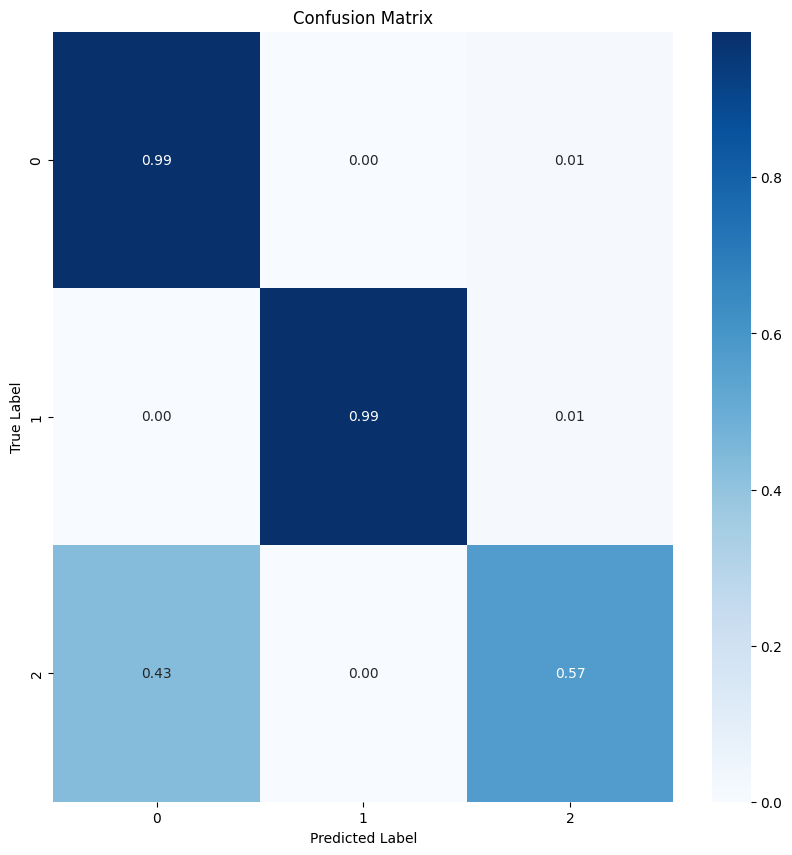

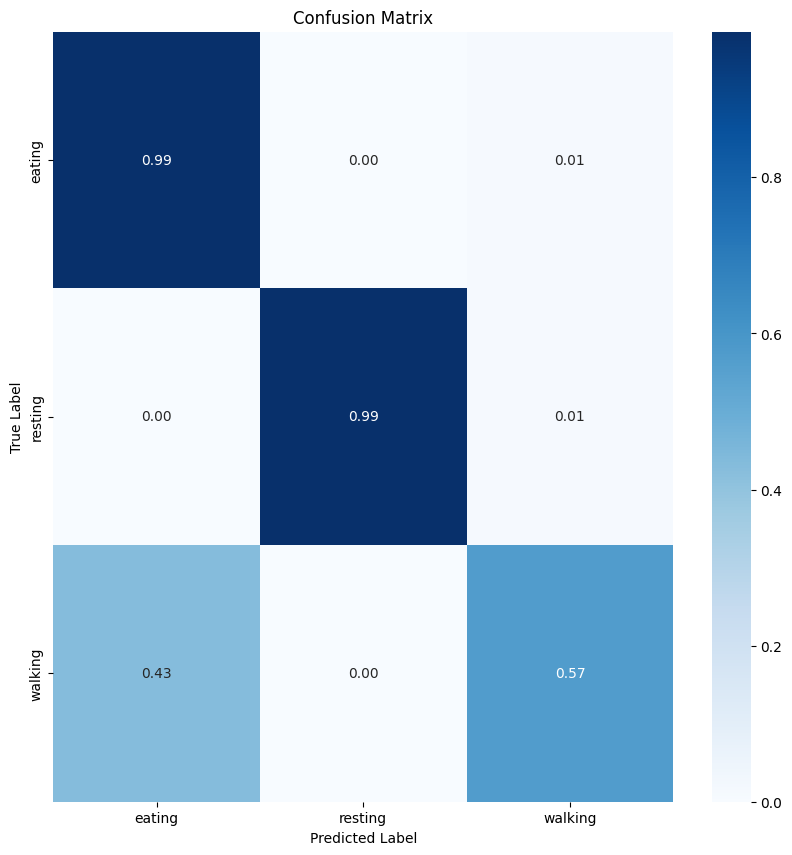

In [74]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Predict on the test data
y_pred = model3.predict(x_val)

# Convert predictions from probability to class labels
y_pred_classes = np.argmax(y_pred, axis=-1)  # Assuming softmax output
y_true_classes = np.argmax(y_val, axis=-1)  # Convert true labels

# Reshape the predictions and true values to a 2D format
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

# Compute the confusion matrix
cm = confusion_matrix(y_true_flat, y_pred_flat)
# If you want, you can also normalize the confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues")
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()


# Define your label names corresponding to the integers
label_names = ['eating', 'resting', 'walking']  # Replace with your actual label names

# Create the confusion matrix plot
plt.figure(figsize=(10, 10))
sns.heatmap(cm_normalized, annot=True, fmt=".2f", cmap="Blues", 
            xticklabels=label_names, yticklabels=label_names)  # Set custom labels
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')
plt.show()

In [65]:
y_pred.shape

(95, 5, 3)

In [58]:
import json
def save_model_run(fit, name: str):

    # Convert the history's values to lists
    history_dict = {key: value for key, value in fit.history.items()}

    # Save as JSON
    with open(f'history_{name}.json', 'w') as f:
        json.dump(history_dict, f)

In [59]:
save_model_run(fit4, 'conv_transformer')

In [61]:
with open('history_conv_transformer_goodfit.json', 'r') as f:
    test = json.load(f)

In [62]:
test

{'loss': [0.9245688319206238,
  0.616095244884491,
  0.5632547736167908,
  0.5294764041900635,
  0.5023446679115295,
  0.4918553829193115,
  0.4984879493713379,
  0.4800112843513489,
  0.47057607769966125,
  0.4606386125087738,
  0.42826658487319946,
  0.4029100239276886,
  0.3403598368167877,
  0.34101924300193787,
  0.36220601201057434,
  0.31177031993865967,
  0.2635596990585327,
  0.2682682275772095,
  0.24989408254623413,
  0.30376526713371277,
  0.22269994020462036,
  0.24579297006130219,
  0.1600131243467331,
  0.13007521629333496,
  0.12421374768018723,
  0.11763425171375275,
  0.1134609580039978,
  0.10386423766613007,
  0.09829547256231308,
  0.09715159982442856,
  0.0796278566122055,
  0.10591934621334076,
  0.12156279385089874,
  0.07267918437719345,
  0.0553363636136055,
  0.037745483219623566,
  0.03833814337849617,
  0.04909377917647362,
  0.04523644223809242,
  0.033265575766563416,
  0.03407835587859154,
  0.05133287236094475,
  0.19203634560108185,
  0.227871760725975

In [44]:
print(f"Validation accuracy before model starts overfitting: {round(val_acc[17], 3)}%")

Validation accuracy before model starts overfitting: 0.973%


In [ ]:
https://stackoverflow.com/questions/60475162/why-is-my-neural-network-validation-accuracy-higher-than-my-training-accuracy-an


CHECK

In [44]:
def define_convTransformer(segment_size=256, sequence_length=5, nfeatures=8, nclasses=3):

    #input_shape = (5120, 8)
    input_shape = (segment_size * sequence_length, nfeatures)

    # Input layer
    inputs = tf.keras.Input(shape=input_shape)

    # CNN layers
    x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(inputs)
    x = layers.MaxPooling1D(2)(x)

    for _ in range(7):
        x = layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(x)
        x = layers.MaxPooling1D(2)(x)

    # Transformer layers
    # query_value_attention_seq = layers.MultiHeadAttention(num_heads=2, key_dim=2)(x, x)

    # # Adding the self attention to the original sequence
    # x = layers.Add()([x, query_value_attention_seq])

    # # Layer Normalization
    # x = layers.LayerNormalization(epsilon=1e-6)(x)

    # # Position-wise Feed-Forward Part
    # x = layers.Conv1D(filters=128, kernel_size=1, activation='relu')(x)
    # x = layers.Conv1D(filters=64, kernel_size=1, activation='relu')(x)

    # # Adding the position-wise feedforward to the sequence
    # x = layers.Add()([x, query_value_attention_seq])

    # Layer Normalization
    # x = layers.LayerNormalization(epsilon=1e-6)(x)

    # Removed Global Average Pooling to keep the time dimension

    # Dense layers for final classification - now it gives a prediction for each time step
    x = layers.TimeDistributed(layers.Dense(sequence_length, activation='relu'))(x)
    outputs = layers.TimeDistributed(layers.Dense(nclasses, activation='softmax'))(x)

    # Creating the model
    model = Model(inputs=inputs, outputs=outputs)

    return model



model4 = define_convTransformer()



model4.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



fit4 = model4.fit(
    x=x_train_convT,
    y=y_train_convT,
    batch_size=32,
    epochs=200,
    validation_split=0.2, 
    shuffle=True
)

Epoch 1/200
12/12 [==============================] - 1s 36ms/step - loss: 1.0855 - accuracy: 0.6859 - val_loss: 0.8954 - val_accuracy: 0.9116
Epoch 2/200
12/12 [==============================] - 0s 23ms/step - loss: 0.8676 - accuracy: 0.8727 - val_loss: 0.4097 - val_accuracy: 0.9474
Epoch 3/200
12/12 [==============================] - 0s 23ms/step - loss: 0.7126 - accuracy: 0.9119 - val_loss: 0.4089 - val_accuracy: 0.9474
Epoch 4/200
12/12 [==============================] - 0s 23ms/step - loss: 0.6605 - accuracy: 0.9210 - val_loss: 0.3765 - val_accuracy: 0.9474
Epoch 5/200
12/12 [==============================] - 0s 24ms/step - loss: 0.6419 - accuracy: 0.9236 - val_loss: 0.3674 - val_accuracy: 0.9453
Epoch 6/200
12/12 [==============================] - 0s 23ms/step - loss: 0.6309 - accuracy: 0.9252 - val_loss: 0.3646 - val_accuracy: 0.9474
Epoch 7/200
12/12 [==============================] - 0s 22ms/step - loss: 0.6193 - accuracy: 0.9247 - val_loss: 0.3601 - val_accuracy: 0.9474
Epoch 

In [45]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots

history = fit4.history

train_loss = history['loss']
val_loss = history['val_loss']
train_acc = history['accuracy']  # Or 'acc' based on your TensorFlow version
val_acc = history['val_accuracy']  # Or 'val_acc' based on your TensorFlow version
epochs = list(range(1, len(train_loss) + 1))

# Create subplots: one row, two columns
fig = make_subplots(rows=1, cols=2, subplot_titles=('Training and Validation Loss', 'Training and Validation Accuracy'))

# Define hover template
hovertemplate = 'Epoch: %{x}<br>Value: %{y:.4f}<extra></extra>'

# First subplot for loss
fig.add_trace(go.Scatter(x=epochs, y=train_loss, mode='lines+markers', name='Training Loss', 
                         marker_color='red', hovertemplate=hovertemplate), row=1, col=1)
fig.add_trace(go.Scatter(x=epochs, y=val_loss, mode='lines+markers', name='Validation Loss', 
                         marker_color='green', hovertemplate=hovertemplate), row=1, col=1)

# Second subplot for accuracy
fig.add_trace(go.Scatter(x=epochs, y=train_acc, mode='lines+markers', name='Training Accuracy', 
                         marker_color='red', hovertemplate=hovertemplate), row=1, col=2)
fig.add_trace(go.Scatter(x=epochs, y=val_acc, mode='lines+markers', name='Validation Accuracy', 
                         marker_color='green', hovertemplate=hovertemplate), row=1, col=2)

# Update xaxis properties
# fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=1)
# fig.update_xaxes(title_text='Epochs', tickmode='linear', row=1, col=2)

# Update yaxis properties
fig.update_yaxes(title_text='Loss', row=1, col=1)
fig.update_yaxes(title_text='Accuracy', row=1, col=2)

# Update layout and show plot
fig.update_layout(title_text='Training and Validation Metrics', showlegend=True)
fig.show()

In [36]:
import numpy as np

def find_optimal_epoch(history):
    val_loss = history['val_loss']
    train_loss = history['loss']
    accuracy = history['accuracy']  # Or 'acc' in older versions of TensorFlow
    
    # Initialize with the first epoch
    optimal_epoch = 0
    min_val_loss = val_loss[0]
    
    for i in range(1, len(val_loss)):
        # Check if the validation loss is increasing
        if val_loss[i] > min_val_loss and train_loss[i] < train_loss[i-1]:
            optimal_epoch = i - 1  # Previous epoch where the validation loss was still decreasing
            break
        else:
            min_val_loss = val_loss[i]
    
    return optimal_epoch, accuracy[optimal_epoch]

# Assume you have a history object from the fit method
optimal_epoch, optimal_accuracy = find_optimal_epoch(history)

print(f"Optimal epoch: {optimal_epoch}")
print(f"Accuracy at optimal epoch: {optimal_accuracy}")


Optimal epoch: 2
Accuracy at optimal epoch: 0.9045093059539795


In [46]:
val_acc[104]

0.9578947424888611

In [68]:
y_train_convT

array([[[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       ...,

       [[0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]],

       [[0., 0., 1.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]],

       [[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]]])

In [ ]:
plt.hist(y_train_convT)